In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input, RandomFlip, RandomRotation, RandomZoom, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.applications import efficientnet_v2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()

170498071/170498071 [==============================] - 7s 0us/step


In [4]:
labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_vehicle = {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1}
label_can_fly = {0: 1, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
label_can_swim = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0}
label_is_big = {0: 1, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1}

In [5]:
def gen_syntetic_arr(Y, syntetic):
    syntetic_array = np.zeros((Y.shape[0], 1))
    for i in range(Y.shape[0]):
        label = int(Y[i])
        syntetic_array[i] = syntetic[label]
    return syntetic_array

In [6]:
y_train_vehicle = gen_syntetic_arr(y_train, label_vehicle)
y_valid_vehicle = gen_syntetic_arr(y_valid, label_vehicle)

y_train_can_fly = gen_syntetic_arr(y_train, label_can_fly)
y_valid_can_fly = gen_syntetic_arr(y_valid, label_can_fly)

y_train_can_swim = gen_syntetic_arr(y_train, label_can_swim)
y_valid_can_swim = gen_syntetic_arr(y_valid, label_can_swim)

y_train_is_big = gen_syntetic_arr(y_train, label_is_big)
y_valid_is_big = gen_syntetic_arr(y_valid, label_is_big)

In [7]:
data_augmentation = tf.keras.Sequential([RandomFlip("horizontal", seed=seed), RandomRotation(0.1, seed=seed), RandomZoom(0.1, seed=seed)])

In [8]:
input_shape = (32, 32, 3) #Cifar10 image size
resized_shape = (224, 224, 3) #EfficientNetV2 model input shape
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = Lambda(lambda image: tf.image.resize(image, resized_shape[:2]))(inputs) #Resize image to  size 224x224
    x = data_augmentation(x)
    base_model = efficientnet_v2.EfficientNetV2S(include_top=False, input_shape=resized_shape, weights="imagenet")
    base_model.trainable = True
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    probability = Dense(num_classes, activation="linear", name='probability')(x)
    vehicle = Dense(1, activation="linear", name='vehicle')(x)
    can_fly = Dense(1, activation="linear", name='can_fly')(x)
    can_swim = Dense(1, activation="linear", name='can_swim')(x)
    is_big = Dense(1, activation="linear", name='is_big')(x)
    model = Model(inputs=inputs, outputs=[probability, vehicle, can_fly, can_swim, is_big])
    return model

In [9]:
model = build_model()

plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

model.compile(optimizer=optimizers.SGD(learning_rate=1e-2, momentum=0.9),
              loss=[SparseCategoricalCrossentropy(from_logits=True), 
                    BinaryCrossentropy(from_logits=True), 
                    BinaryCrossentropy(from_logits=True), 
                    BinaryCrossentropy(from_logits=True), 
                    BinaryCrossentropy(from_logits=True)],
              loss_weights=[1, 1, 1, 1, 1],
              metrics={'probability': 'accuracy', 'vehicle': 'accuracy', 'can_fly': 'accuracy', 'can_swim': 'accuracy', 'is_big': 'accuracy'})

model.summary()
print("\n")

history = model.fit(X_train, [y_train, y_train_vehicle, y_train_can_fly, y_train_can_swim, y_train_is_big],
                    validation_split=0.2,
                    epochs=20,
                    callbacks=[plateau, earlystopping])

82420632/82420632 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 efficientnetv2-s (Functional)  (None, 7, 7, 1280)   20331360    ['sequential[0][0]']             
                             

In [17]:
results = model.evaluate(X_valid, [y_valid, y_valid_vehicle, y_valid_can_fly, y_valid_can_swim, y_valid_is_big])
print(f'Loss: {100*round(results[1], 4)}% \nCassification Accuracy: {100*round(results[6], 4)}%')

313/313 [==============================] - 37s 119ms/step - loss: 0.1449 - probability_loss: 0.0822 - vehicle_loss: 0.0059 - can_fly_loss: 0.0200 - can_swim_loss: 0.0175 - is_big_loss: 0.0192 - probability_accuracy: 0.9805 - vehicle_accuracy: 0.9986 - can_fly_accuracy: 0.9948 - can_swim_accuracy: 0.9954 - is_big_accuracy: 0.9954
Loss: 8.200000000000001% 
Cassification Accuracy: 98.05%


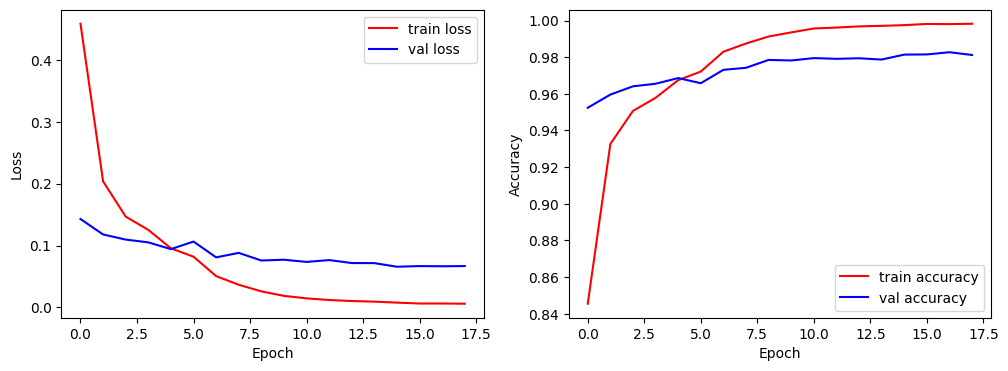

In [26]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["probability_loss"], c="r", label="train loss")
ax[0].plot(history.history["val_probability_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["probability_accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_probability_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

In [13]:
model.save("model.keras")

313/313 [==============================] - 33s 106ms/step


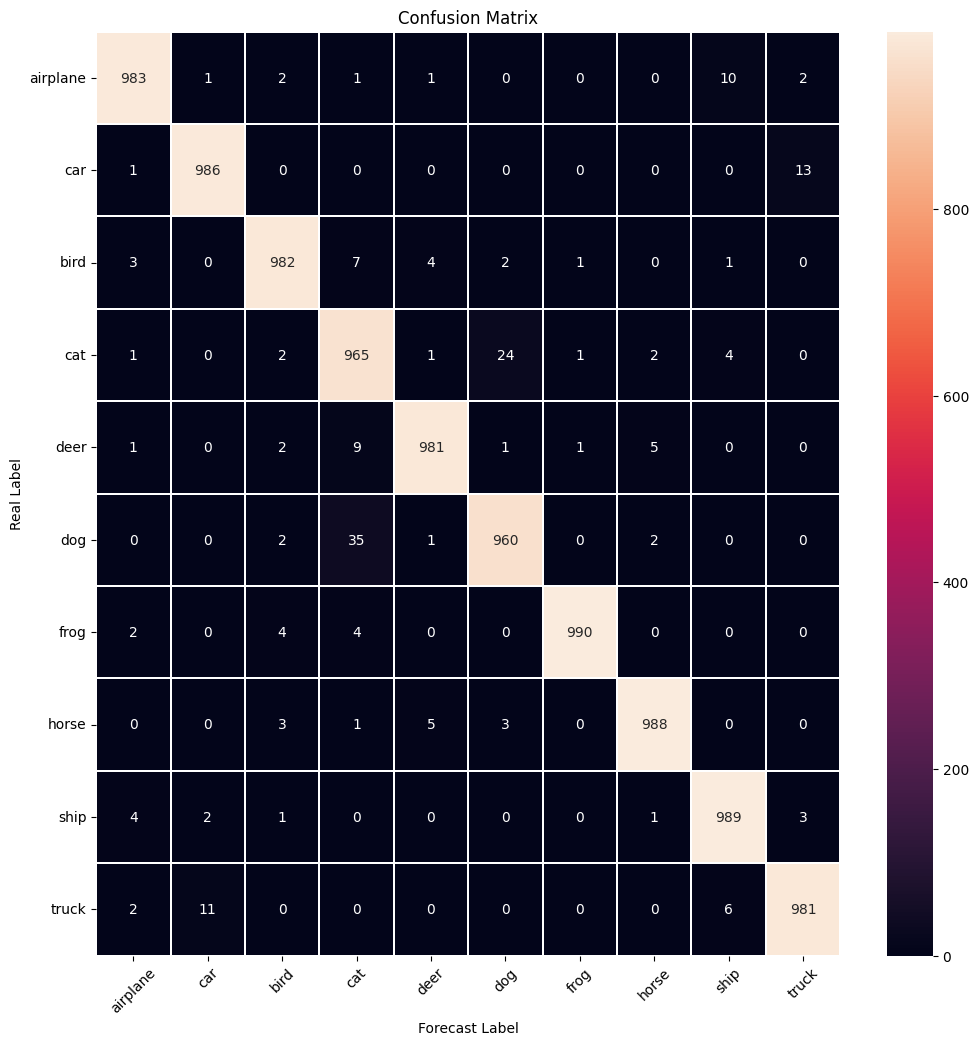

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_valid)#10k images (10 classes x 1000 examples)
y_pred_classes = np.argmax(y_pred[0], axis = 1)
conf_matrix = confusion_matrix(y_valid, y_pred_classes) 

f,ax = plt.subplots(figsize = (12,12))
sns.heatmap(conf_matrix, annot=True, linewidths=0.1, linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Forecast Label")
plt.ylabel("Real Label")
plt.title("Confusion Matrix")
ax.set_xticklabels([_ for _ in labels], rotation=45)
ax.set_yticklabels([_ for _ in labels], rotation=0)

plt.show()